In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import shutil

# Import Data

## Ekstrak emotion dari audio files dengan regex

In [2]:
base_dirs = ["Audio_Song_Actors_01-24", "Audio_Speech_Actors_01-24"]
output_dir = r"Emotions"

os.makedirs(output_dir, exist_ok=True)

# Regex for filenames like: 03-02-01-01-01-01-01.wav
pattern = re.compile(
    r"(?P<modality>\d{2})-(?P<vocal_channel>\d{2})-(?P<emotion>\d{2})-(?P<intensity>\d{2})-(?P<statement>\d{2})-(?P<repetition>\d{2})-(?P<actor>\d{2})\.wav"
)

emotion_labels = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised",
}

for base_dir in base_dirs:
    for actor_folder in os.listdir(base_dir):
        actor_path = os.path.join(base_dir, actor_folder)
        if not os.path.isdir(actor_path):
            continue

        # Loop through audio files in each actor folder
        for file_name in os.listdir(actor_path):
            match = pattern.match(file_name)
            if not match:
                continue  # skip invalid names

            emotion_code = match.group("emotion")
            emotion = emotion_labels.get(emotion_code, "unknown")

            # Create emotion folder
            emotion_path = os.path.join(output_dir, emotion)
            os.makedirs(emotion_path, exist_ok=True)

            # Copy or move file (use move if you prefer)
            src = os.path.join(actor_path, file_name)
            dst = os.path.join(emotion_path, file_name)
            shutil.copy2(src, dst)



## Taruh didalam dataframe

In [3]:
import os
import pandas as pd

# Label dictionaries
modality = {'01': 'full-AV', '02': 'video-only', '03': 'audio-only'}
vocal_channel = {'01': 'speech', '02': 'song'}
emotion = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
}
intensity = {'01': 'normal', '02': 'strong'}
statement = {'01': 'Kids are talking by the door', '02': 'Dogs are sitting by the door'}
repetition = {'01': '1st repetition', '02': '2nd repetition'}

# Folder with emotion subfolders
base_path = "Emotions"

data = []

# Loop through each emotion folder
for emotion_folder in os.listdir(base_path):
    emotion_path = os.path.join(base_path, emotion_folder)
    if not os.path.isdir(emotion_path):
        continue
    
    for filename in os.listdir(emotion_path):
        if not filename.lower().endswith('.wav'):
            continue
        
        parts = filename.split('.')[0].split('-')
        if len(parts) != 7:
            continue
        
        file_info = {
            'Filename': filename,
            'Filepath': os.path.join(emotion_path, filename),
            'Modality': modality.get(parts[0]),
            'Vocal Channel': vocal_channel.get(parts[1]),
            'Emotion': emotion.get(parts[2]),
            'Intensity': intensity.get(parts[3]),
            'Statement': statement.get(parts[4]),
            'Repetition': repetition.get(parts[5]),
            'Actor': int(parts[6]),
            'Gender': 'male' if int(parts[6]) % 2 == 1 else 'female'
        }
        data.append(file_info)

df = pd.DataFrame(data)
print(df.head())
print(f"\n✅ Total files loaded: {len(df)}")


                   Filename                                 Filepath  \
0  03-01-05-01-01-01-01.wav  Emotions\angry\03-01-05-01-01-01-01.wav   
1  03-01-05-01-01-01-02.wav  Emotions\angry\03-01-05-01-01-01-02.wav   
2  03-01-05-01-01-01-03.wav  Emotions\angry\03-01-05-01-01-01-03.wav   
3  03-01-05-01-01-01-04.wav  Emotions\angry\03-01-05-01-01-01-04.wav   
4  03-01-05-01-01-01-05.wav  Emotions\angry\03-01-05-01-01-01-05.wav   

     Modality Vocal Channel Emotion Intensity                     Statement  \
0  audio-only        speech   angry    normal  Kids are talking by the door   
1  audio-only        speech   angry    normal  Kids are talking by the door   
2  audio-only        speech   angry    normal  Kids are talking by the door   
3  audio-only        speech   angry    normal  Kids are talking by the door   
4  audio-only        speech   angry    normal  Kids are talking by the door   

       Repetition  Actor  Gender  
0  1st repetition      1    male  
1  1st repetition     

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2452 entries, 0 to 2451
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Filename       2452 non-null   object
 1   Filepath       2452 non-null   object
 2   Modality       2452 non-null   object
 3   Vocal Channel  2452 non-null   object
 4   Emotion        2452 non-null   object
 5   Intensity      2452 non-null   object
 6   Statement      2452 non-null   object
 7   Repetition     2452 non-null   object
 8   Actor          2452 non-null   int64 
 9   Gender         2452 non-null   object
dtypes: int64(1), object(9)
memory usage: 191.7+ KB


# EDA

In [22]:
df.isnull().sum()

Filename         0
Filepath         0
Modality         0
Vocal Channel    0
Emotion          0
Intensity        0
Statement        0
Repetition       0
Actor            0
Gender           0
dtype: int64

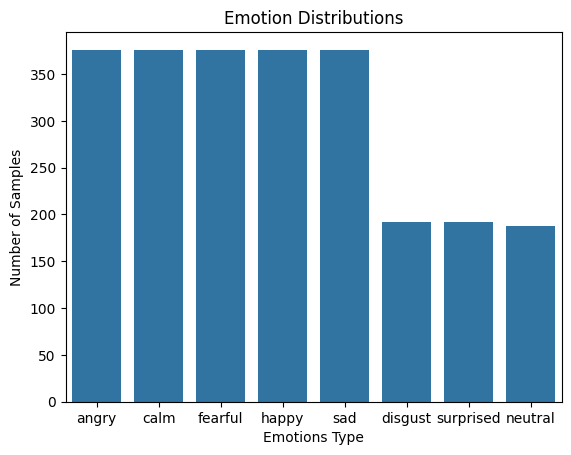

In [23]:
plt.Figure(figsize=(10,5))
sns.countplot(x='Emotion', data=df, order=df['Emotion'].value_counts().index)
plt.title('Emotion Distributions')
plt.xlabel('Emotions Type')
plt.ylabel('Number of Samples')
plt.show()

In [76]:
emotions_count = df['Emotion'].value_counts(normalize=True) * 100

print(emotions_count.round(2))

Emotion
calm       18.18
happy      18.18
sad        18.18
angry      18.18
fearful    18.18
neutral     9.09
Name: proportion, dtype: float64


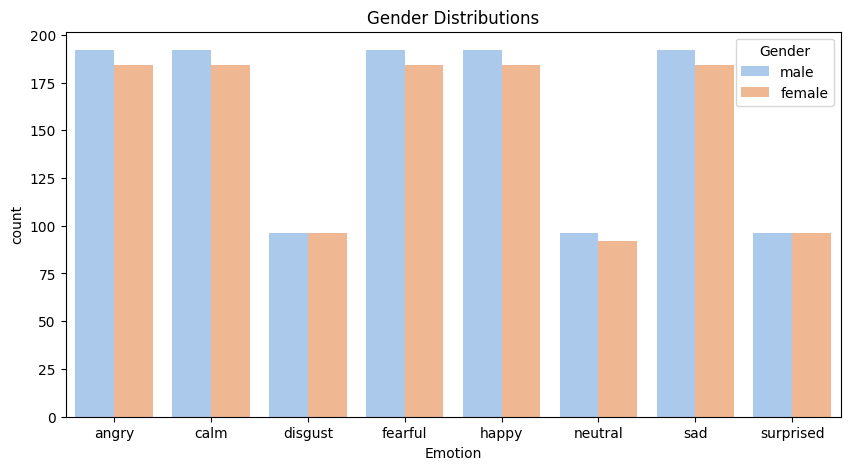

In [24]:
plt.figure(figsize=(10,5))
sns.countplot(x='Emotion', hue='Gender' ,data=df, palette='pastel')
plt.title('Gender Distributions')
plt.show()

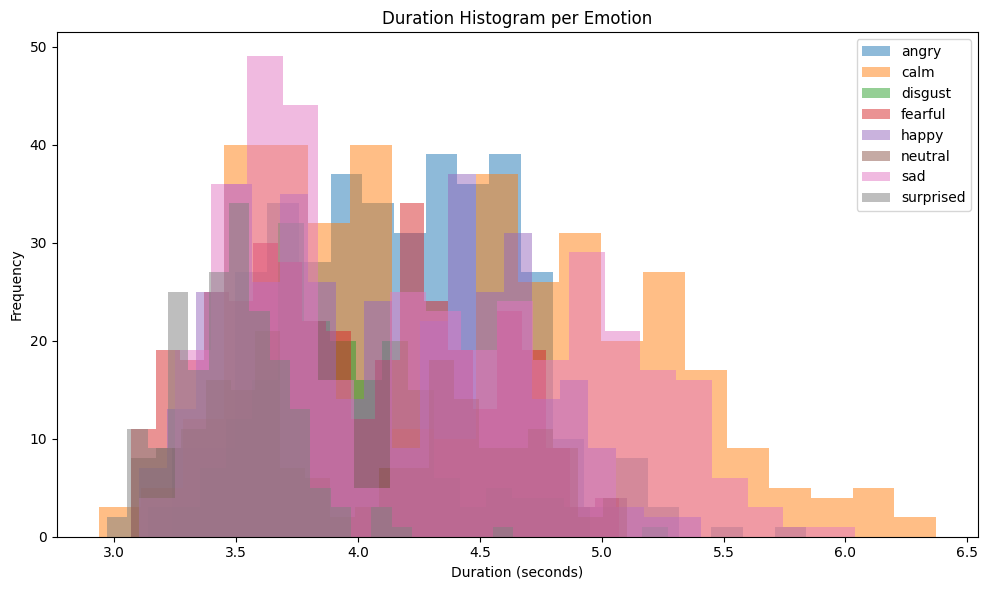

In [35]:
durations = []
for filepath in df["Filepath"]:
    try:
        duration = librosa.get_duration(path=filepath)
    except Exception as e:
        print(f"Error reading {filepath}: {e}")
        duration = None
    durations.append(duration)

df["Duration"] = durations

plt.figure(figsize=(10, 6))
for emotion in df["Emotion"].unique():
    subset = df[df["Emotion"] == emotion]
    plt.hist(subset["Duration"], bins=20, alpha=0.5, label=emotion)
plt.title("Duration Histogram per Emotion")
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

# Preprocessing

In [10]:
import seaborn as sns
import librosa, librosa.display
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

In [11]:
df['Actor'] = df['Actor'].astype(int)
df['path'] = df.apply(lambda r: os.path.join(base_path, f"Actor_{int(r['Actor']):02d}", r['Filename']), axis=1)

print("Total Files: ", len(df))
print(df['Emotion'].value_counts())
print(df[['Actor', 'Gender']].value_counts())

Total Files:  2452
Emotion
angry        376
calm         376
fearful      376
happy        376
sad          376
disgust      192
surprised    192
neutral      188
Name: count, dtype: int64
Actor  Gender
1      male      104
2      female    104
3      male      104
4      female    104
5      male      104
6      female    104
7      male      104
8      female    104
9      male      104
10     female    104
11     male      104
12     female    104
13     male      104
14     female    104
15     male      104
16     female    104
17     male      104
19     male      104
20     female    104
21     male      104
23     male      104
22     female    104
24     female    104
18     female     60
Name: count, dtype: int64


In [12]:
df.drop(columns=['path'])

,Filename,Filepath,Modality,Vocal Channel,Emotion,Intensity,Statement,Repetition,Actor,Gender
0,03-01-05-01-01-01-01.wav,Emotions\angry\03-01-05-01-01-01-01.wav,audio-only,speech,angry,normal,Kids are talking by the door,1st repetition,1,male
1,03-01-05-01-01-01-02.wav,Emotions\angry\03-01-05-01-01-01-02.wav,audio-only,speech,angry,normal,Kids are talking by the door,1st repetition,2,female
2,03-01-05-01-01-01-03.wav,Emotions\angry\03-01-05-01-01-01-03.wav,audio-only,speech,angry,normal,Kids are talking by the door,1st repetition,3,male
3,03-01-05-01-01-01-04.wav,Emotions\angry\03-01-05-01-01-01-04.wav,audio-only,speech,angry,normal,Kids are talking by the door,1st repetition,4,female
4,03-01-05-01-01-01-05.wav,Emotions\angry\03-01-05-01-01-01-05.wav,audio-only,speech,angry,normal,Kids are talking by the door,1st repetition,5,male
...,...,...,...,...,...,...,...,...,...,...
2447,03-01-08-02-02-02-20.wav,Emotions\surprised\03-01-08-02-02-02-20.wav,audio-only,speech,surprised,strong,Dogs are sitting by the door,2nd repetition,20,female
2448,03-01-08-02-02-02-21.wav,Emotions\surprised\03-01-08-02-02-02-21.wav,audio-only,speech,surprised,strong,Dogs are sitting by the door,2nd repetition,21,male
2449,03-01-08-02-02-02-22.wav,Emotions\surprised\03-01-08-02-02-02-22.wav,audio-only,speech,surprised,strong,Dogs are sitting by the door,2nd repetition,22,female
2450,03-01-08-02-02-02-23.wav,Emotions\surprised\03-01-08-02-02-02-23.wav,audio-only,speech,surprised,strong,Dogs are sitting by the door,2nd repetition,23,male


In [13]:
# Parameters
SR = 16000
N_Mels = 128
Target_Width = 128

# --- Helper functions ---
def load_audio(path, sr=SR):
    y, _ = librosa.load(path, sr=sr)
    y, _ = librosa.effects.trim(y)
    return y

def wav_to_mel(path, sr=SR, n_mels=N_Mels, target_width=Target_Width):
    try:
        y = load_audio(path, sr)
    except Exception as e:
        print(f"Error loading {path}: {e}")
        return None

    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    S_db = librosa.power_to_db(S, ref=np.max)

    if S_db.shape[1] < target_width:
        pad_width = target_width - S_db.shape[1]
        S_db = np.pad(S_db, ((0, 0), (0, pad_width)), mode='constant')
    else:
        S_db = S_db[:, :target_width]

    S_Norm = (S_db - S_db.min()) / (S_db.max() - S_db.min() + 1e-6)

    img = S_Norm.astype(np.float32)
    img3 = np.stack([img, img, img], axis=-1)
    return img3

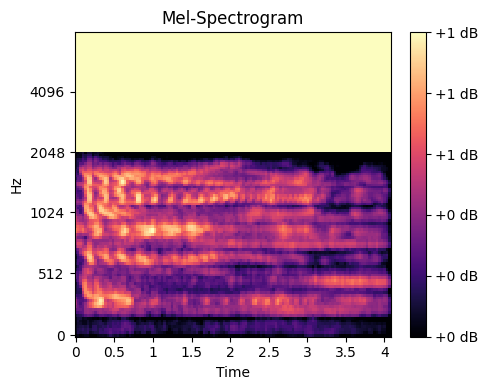

In [14]:
sample_img = wav_to_mel(df.iloc[0]['Filepath'])
plt.figure(figsize=(5, 4))
librosa.display.specshow(
    sample_img[:, :, 0].T,
    sr=SR,
    x_axis='time',
    y_axis='mel'
)
plt.title("Mel-Spectrogram")
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

Dari pola garis-garis horizontal yang jelas, bisa disimpulkan ini adalah suara bernada yang stabil, seperti vokal manusia yang sedang bernyanyi atau alat musik yang dimainkan.

Apakah Baik untuk Machine Learning (Segmentasi Audio)?
Ya, audio ini sangat baik untuk melatih model machine learning untuk tugas segmentasi audio.

Alasannya:

Sinyal Sangat Jernih: Suaranya sangat jelas dan bersih dari noise (gangguan). Ini memudahkan model untuk mengenali pola utamanya.

Fitur Stabil: Karakteristik suara (pola garis-garisnya) konsisten selama 4 detik, menjadikannya contoh yang ideal untuk dipelajari oleh AI.

Batas yang Jelas: Suara dimulai dan berlangsung dengan jelas, sehingga sempurna untuk melatih model dalam mendeteksi kapan sebuah segmen audio dimulai dan berakhir.

In [15]:
from tqdm import tqdm

labels = df['Emotion'].values
le = LabelEncoder()
y_all = le.fit_transform(labels)
num_classes = len(le.classes_)

print("Classes:", le.classes_)
print("Number of classes:", num_classes)

x_list = []
y_list = []

for p, lab in tqdm(zip(df['Filepath'], y_all), total=len(df)):
    img = wav_to_mel(p)
    if img is None:
        continue
    x_list.append(img)
    y_list.append(lab)

# --- Stack to arrays ---
x = np.stack(x_list)
y = np.array(y_list)

print("✅ Done!")
print("x shape:", x.shape)
print("y shape:", y.shape)


Classes: ['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']
Number of classes: 8


100%|██████████| 2452/2452 [01:20<00:00, 30.50it/s]


✅ Done!
x shape: (2452, 128, 128, 3)
y shape: (2452,)


# Data Splitting and Augmentation

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, stratify=y_train, random_state=42)

print(x_train.shape, x_val.shape, x_test.shape)

(1764, 128, 128, 3) (197, 128, 128, 3) (491, 128, 128, 3)


In [20]:
def add_noise(y, noise_factor = 0.005):
  noise = np.random(len(y))
  return y + noise_factor * noise

def pitch_shift(y, sr, n_steps = 2):
  return librosa.effects.pitch_shift(y, sr, n_steps)

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
  rotation_range=15,
  width_shift_range=0.1,
  height_shift_range=0.1,
  horizontal_flip=True
)

datagen.fit(x_train)

# <b>Advanced CNN</b> (ResNet)


## Training 

In [22]:
from tensorflow.keras import layers, models

In [23]:
from tensorflow.keras import layers, models
def build_resnet(input_shape=(128, 128, 3), num_classes=8):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(64, (3,3), strides=1, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    def residual_block(x, filters):
        shortcut = x
        x = layers.Conv2D(filters, (3,3), padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(filters, (3,3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        if shortcut.shape[-1] != filters:
            shortcut = layers.Conv2D(filters, (1,1), padding='same')(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)
        x = layers.Add()([shortcut, x])
        x = layers.Activation('relu')(x)
        return x

    x = residual_block(x, 64)
    x = layers.MaxPooling2D((2,2))(x)

    x = residual_block(x, 128)
    x = layers.MaxPooling2D((2,2))(x)

    x = residual_block(x, 256)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs, name="ResNet_AudioEmotion")
    return model


num_classes = len(np.unique(y))
model = build_resnet(input_shape=(128, 128, 3), num_classes=num_classes)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "ResNet_AudioEmotion"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 128, 128,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 64, 64,    │     36,928 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 64, 64,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 64, 64,    │          0 │ max_pooling2d_4[… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 64,    │          0 │ add_3[0][0]       │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_5[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 32, 32,    │      8,320 │ max_pooling2d_5[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 32, 32,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_13[0][0] 

 Total params: 1,231,112 (4.70 MB)

 Trainable params: 1,228,424 (4.69 MB)

 Non-trainable params: 2,688 (10.50 KB)

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint(
    'resnet_best.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
    min_lr=1e-7
)

history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=20,
    batch_size=16,
    callbacks=[checkpoint, early_stop, reduce_lr],
    verbose=1
)

Epoch 1/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.2336 - loss: 2.1520

111/111 ━━━━━━━━━━━━━━━━━━━━ 51s 460ms/step - accuracy: 0.2704 - loss: 2.0157 - val_accuracy: 0.1523 - val_loss: 3.6536 - learning_rate: 1.0000e-04
Epoch 2/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 52s 473ms/step - accuracy: 0.3339 - loss: 1.7525 - val_accuracy: 0.1523 - val_loss: 5.8792 - learning_rate: 1.0000e-04
Epoch 3/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 52s 470ms/step - accuracy: 0.3951 - loss: 1.5937 - val_accuracy: 0.1523 - val_loss: 5.6091 - learning_rate: 1.0000e-04
Epoch 4/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - accuracy: 0.4185 - loss: 1.4811

111/111 ━━━━━━━━━━━━━━━━━━━━ 52s 472ms/step - accuracy: 0.4172 - loss: 1.5059 - val_accuracy: 0.2640 - val_loss: 3.4288 - learning_rate: 1.0000e-04
Epoch 5/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.4507 - loss: 1.4416

111/111 ━━━━━━━━━━━━━━━━━━━━ 52s 465ms/step - accuracy: 0.4399 - loss: 1.4581 - val_accuracy: 0.3401 - val_loss: 2.9947 - learning_rate: 1.0000e-04
Epoch 6/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 52s 471ms/step - accuracy: 0.4824 - loss: 1.3498 - val_accuracy: 0.3401 - val_loss: 2.0294 - learning_rate: 1.0000e-04
Epoch 7/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.5061 - loss: 1.2698

111/111 ━━━━━━━━━━━━━━━━━━━━ 52s 469ms/step - accuracy: 0.5108 - loss: 1.2805 - val_accuracy: 0.4518 - val_loss: 1.4528 - learning_rate: 1.0000e-04
Epoch 8/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.5506 - loss: 1.2093

111/111 ━━━━━━━━━━━━━━━━━━━━ 52s 465ms/step - accuracy: 0.5505 - loss: 1.2074 - val_accuracy: 0.5279 - val_loss: 1.2533 - learning_rate: 1.0000e-04
Epoch 9/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 51s 460ms/step - accuracy: 0.5737 - loss: 1.1184 - val_accuracy: 0.4365 - val_loss: 1.4945 - learning_rate: 1.0000e-04
Epoch 10/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 52s 466ms/step - accuracy: 0.6117 - loss: 1.0312 - val_accuracy: 0.5076 - val_loss: 1.4221 - learning_rate: 1.0000e-04
Epoch 11/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 52s 472ms/step - accuracy: 0.6553 - loss: 0.9350 - val_accuracy: 0.4619 - val_loss: 1.6487 - learning_rate: 1.0000e-04
Epoch 12/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.6855 - loss: 0.8644

111/111 ━━━━━━━━━━━━━━━━━━━━ 52s 464ms/step - accuracy: 0.6825 - loss: 0.8553 - val_accuracy: 0.5685 - val_loss: 1.3747 - learning_rate: 1.0000e-04
Epoch 13/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 52s 469ms/step - accuracy: 0.7489 - loss: 0.7025 - val_accuracy: 0.5381 - val_loss: 1.3285 - learning_rate: 5.0000e-05
Epoch 14/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 52s 469ms/step - accuracy: 0.7693 - loss: 0.6560 - val_accuracy: 0.5584 - val_loss: 1.4414 - learning_rate: 5.0000e-05
Epoch 15/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - accuracy: 0.7806 - loss: 0.6211

111/111 ━━━━━━━━━━━━━━━━━━━━ 52s 470ms/step - accuracy: 0.7846 - loss: 0.6146 - val_accuracy: 0.6599 - val_loss: 1.0027 - learning_rate: 5.0000e-05
Epoch 16/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 52s 473ms/step - accuracy: 0.8146 - loss: 0.5549 - val_accuracy: 0.6396 - val_loss: 1.0829 - learning_rate: 5.0000e-05
Epoch 17/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 52s 468ms/step - accuracy: 0.8322 - loss: 0.5194 - val_accuracy: 0.6244 - val_loss: 1.0372 - learning_rate: 5.0000e-05
Epoch 18/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 51s 463ms/step - accuracy: 0.8600 - loss: 0.4640 - val_accuracy: 0.6041 - val_loss: 1.1335 - learning_rate: 5.0000e-05
Epoch 19/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 50s 453ms/step - accuracy: 0.8583 - loss: 0.4460 - val_accuracy: 0.6497 - val_loss: 1.0731 - learning_rate: 5.0000e-05
Epoch 20/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 51s 460ms/step - accuracy: 0.8940 - loss: 0.3752 - val_accuracy: 0.6599 - val_loss: 1.0217 - learning_rate: 2.5000e-05


## Evalution

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.6578 - loss: 0.9583
test accuracy:  0.657841145992279
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step
              precision    recall  f1-score   support

       angry       0.86      0.67      0.75        75
        calm       0.68      0.93      0.79        75
     disgust       0.77      0.51      0.62        39
     fearful       0.67      0.55      0.60        75
       happy       0.63      0.60      0.62        75
     neutral       0.59      0.76      0.67        38
         sad       0.58      0.47      0.52        75
   surprised       0.52      0.85      0.65        39

    accuracy                           0.66       491
   macro avg       0.66      0.67      0.65       491
weighted avg       0.67      0.66      0.65       491



<Figure size 800x600 with 0 Axes>

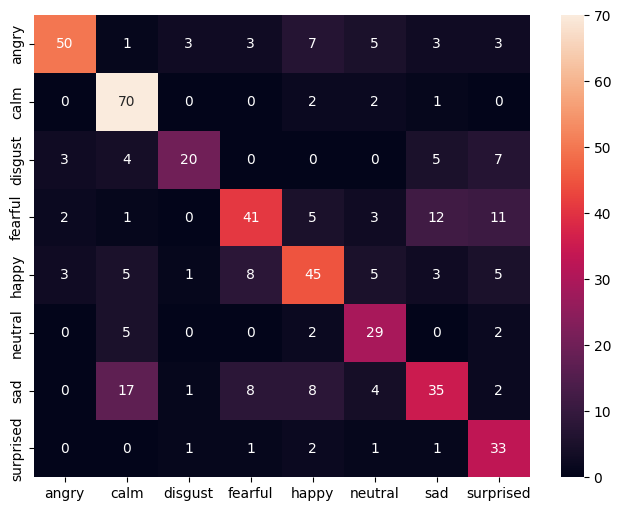

In [26]:
model.load_weights('resnet_best.h5')
test_loss, test_acc = model.evaluate(x_test, y_test, verbose = 1)
print("test accuracy: ", test_acc)

y_pred = np.argmax(model.predict(x_test), axis=1)
print(classification_report(y_test, y_pred, target_names=le.classes_))

Confusion_Matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
plt.figure(figsize=(8,6)); sns.heatmap(Confusion_Matrix, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.show()

## Tuning

In [27]:
checkpoint = ModelCheckpoint('resnet_best.h5', monitor = 'val_accuracy', save_best_only = True, mode = 'max')
early_stop = EarlyStopping(monitor = 'val_loss', patience=6, restore_best_weights=True)
ReduceLRON = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 3, min_lr = 1e-7)

In [28]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y = y_train)
class_weights = dict(enumerate(class_weights))

model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=16, callbacks = [checkpoint, early_stop, ReduceLRON])

Epoch 1/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.8171 - loss: 0.5191

111/111 ━━━━━━━━━━━━━━━━━━━━ 53s 478ms/step - accuracy: 0.8254 - loss: 0.5037 - val_accuracy: 0.6244 - val_loss: 1.0044 - learning_rate: 2.5000e-05
Epoch 2/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.8348 - loss: 0.4930

111/111 ━━━━━━━━━━━━━━━━━━━━ 52s 471ms/step - accuracy: 0.8282 - loss: 0.5010 - val_accuracy: 0.6954 - val_loss: 0.9070 - learning_rate: 2.5000e-05
Epoch 3/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 52s 465ms/step - accuracy: 0.8554 - loss: 0.4690 - val_accuracy: 0.6954 - val_loss: 0.8739 - learning_rate: 2.5000e-05
Epoch 4/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 51s 458ms/step - accuracy: 0.8583 - loss: 0.4523 - val_accuracy: 0.6548 - val_loss: 1.0969 - learning_rate: 2.5000e-05
Epoch 5/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 52s 469ms/step - accuracy: 0.8707 - loss: 0.4169 - val_accuracy: 0.6802 - val_loss: 0.9119 - learning_rate: 2.5000e-05
Epoch 6/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 54s 483ms/step - accuracy: 0.8634 - loss: 0.4228 - val_accuracy: 0.6396 - val_loss: 1.0789 - learning_rate: 2.5000e-05
Epoch 7/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 52s 465ms/step - accuracy: 0.8940 - loss: 0.3686 - val_accuracy: 0.6904 - val_loss: 0.8762 - learning_rate: 1.2500e-05
Epoch 8/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 52s 471ms/step - 

111/111 ━━━━━━━━━━━━━━━━━━━━ 52s 468ms/step - accuracy: 0.9065 - loss: 0.3357 - val_accuracy: 0.7107 - val_loss: 0.8792 - learning_rate: 1.2500e-05
Epoch 10/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 52s 465ms/step - accuracy: 0.9121 - loss: 0.3423 - val_accuracy: 0.6904 - val_loss: 0.8428 - learning_rate: 1.2500e-05
Epoch 11/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 52s 470ms/step - accuracy: 0.9053 - loss: 0.3351 - val_accuracy: 0.7107 - val_loss: 0.8484 - learning_rate: 1.2500e-05
Epoch 12/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 52s 469ms/step - accuracy: 0.9133 - loss: 0.3211 - val_accuracy: 0.6751 - val_loss: 0.9115 - learning_rate: 1.2500e-05
Epoch 13/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 51s 459ms/step - accuracy: 0.9240 - loss: 0.2980 - val_accuracy: 0.7005 - val_loss: 0.9076 - learning_rate: 1.2500e-05
Epoch 14/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - accuracy: 0.9188 - loss: 0.2966

111/111 ━━━━━━━━━━━━━━━━━━━━ 52s 471ms/step - accuracy: 0.9212 - loss: 0.2975 - val_accuracy: 0.7310 - val_loss: 0.8693 - learning_rate: 6.2500e-06
Epoch 15/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 52s 470ms/step - accuracy: 0.9303 - loss: 0.2730 - val_accuracy: 0.7056 - val_loss: 0.8924 - learning_rate: 6.2500e-06
Epoch 16/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 51s 463ms/step - accuracy: 0.9303 - loss: 0.2815 - val_accuracy: 0.7208 - val_loss: 0.8931 - learning_rate: 6.2500e-06


In [30]:
test_loss, test_acc = model.evaluate(x_test, y_test)

y_pred = model.predict(x_test)

y_pred_classes = np.argmax(y_pred, axis = 1)
y_true = y_test

emotion_labels = ['angry', 'calm', 'fearful', 'happy', 'neutral', 'sad', 'disgust', 'surprised']
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)
print(classification_report(y_true, y_pred_classes, target_names=emotion_labels))

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 0.6619 - loss: 0.9155
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step
Test Loss: 0.915455162525177
Test Accuracy: 0.6619144678115845
              precision    recall  f1-score   support

       angry       0.65      0.84      0.73        75
        calm       0.83      0.76      0.79        75
     fearful       0.66      0.74      0.70        39
       happy       0.51      0.69      0.59        75
     neutral       0.67      0.57      0.62        75
         sad       0.90      0.68      0.78        38
     disgust       0.60      0.45      0.52        75
   surprised       0.70      0.54      0.61        39

    accuracy                           0.66       491
   macro avg       0.69      0.66      0.67       491
weighted avg       0.68      0.66      0.66       491



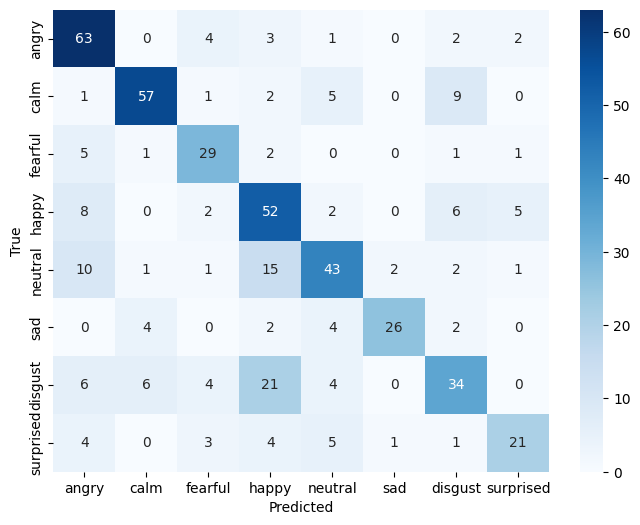

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=emotion_labels, yticklabels=emotion_labels, cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()


In [32]:
import numpy as np, collections
print("Support true:", np.bincount(y_true))
print("Support pred:", np.bincount(y_pred_classes))

Support true: [75 75 39 75 75 38 75 39]
Support pred: [ 97  69  44 101  64  29  57  30]


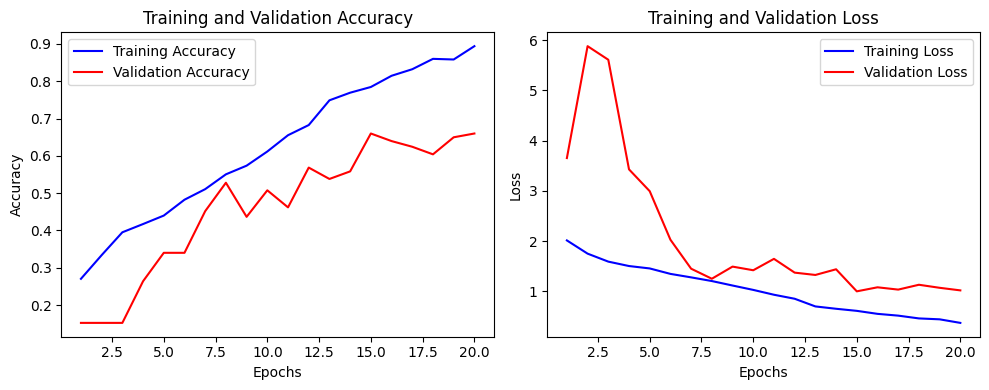

In [33]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history.get('val_accuracy')
    loss = history.history['loss']
    val_loss = history.history.get('val_loss')

    epochs = range(1, len(acc) + 1)

    # Accuracy
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    if val_acc:
        plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    if val_loss:
        plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

Model disini terlihat sedikit underfitting, dilihat dari:
- Val accuracy dan train accuracy belum converge, mungkin membutuhkan waktu training yang lebih lama. Butuh training lebih lama dengan Early stopping


## Add tuning layers

In [ ]:
# from tensorflow.keras.layers import Dropout
# from tensorflow.keras.regularizers import l2

# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.4))
# model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))


AttributeError: 'Functional' object has no attribute 'add'